In [1]:
library(MCMCglmm)
library(lme4) #random effect'lmerTest' should be used in place of 'lme4', If lmer model p-values are desired 
library(brms) #preditability with baysian approach
library(ggplot2) #plot
library(MuMIn) #r.squaredGLMM
library(merTools) #simulations
library(optimx) #different optimizer to help model to converge 
#library("posterior") #not sue I am using it as brms should have it already in its package, althought it is base don this package

Warning message:
"package 'MCMCglmm' was built under R version 4.0.5"
Loading required package: Matrix

Loading required package: coda

Warning message:
"package 'coda' was built under R version 4.0.5"
Loading required package: ape

Warning message:
"package 'brms' was built under R version 4.0.5"
Loading required package: Rcpp

Loading 'brms' package (version 2.16.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:lme4':

    ngrps


The following object is masked from 'package:MCMCglmm':

    me


The following object is masked from 'package:stats':

    ar


Warning message:
"package 'MuMIn' was built under R version 4.0.5"

Attaching package: 'MuMIn'


The following object is masked from 'package:brms':

    loo


Warning message:
"package 'merTools' was built under R version 4.0.5"
Loading required package:

In [2]:
#citation("merTools")

In [3]:
library(parallel)
my.cores = detectCores()

library(lme4)
library(arm)
library(MuMIn)
library(tidyverse)
library(plyr)
library(broom)
library(coda)
library(grid)
library(gridExtra)
library(brms)
library(broom.mixed)
library(merTools)
library(tidybayes)
library(parallel)

# Download data

In [4]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
path_model = file.path(path_adapt,'repeatability_model')
df = read.csv(file.path(path_adapt,'df_MVT_4individuality_withPCA.csv'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$WIB = as.factor(df$WIB) 
df$TrackingSystemID = as.factor(df$TrackingSystemID) 
#mean-centering of the environmental variable so that intercepts reflect average values for the population and individuals
df$cDIB = as.integer(df$DIB) 
df$cDIBfact = as.factor(df$cDIB) 
df$RearingPenID = as.factor(df$RearingPenID) 
df$InitialWeight_kg = df$InitialWeight/1000
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment) 
#scale
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$InitialWeight_kg_scale = scale(df$InitialWeight_kg, center=TRUE, scale=TRUE)
df$cDIB_scale = scale(df$cDIB, center=TRUE, scale=TRUE)
#orthogonal polynomial of DIB
df$cDIB.ortho1 = poly(df$cDIB_scale, 2, raw=FALSE)[,1] # orthogonal version of DIB
df$cDIB.ortho2 = poly(df$cDIB_scale, 2, raw=FALSE)[,2] # orthogonal version of DIB^2
print(dim(df))
summary(df)

[1] 5361   36


 WIB         HenID           RPen            DIB          CLASS     
 2:333   hen_1  :  43   Min.   :1.000   Min.   :11.00   LEXP :1125  
 3:795   hen_105:  43   1st Qu.:2.000   1st Qu.:23.00   MEXP :1441  
 4:894   hen_110:  43   Median :2.000   Median :33.00   Other:2795  
 5:931   hen_113:  43   Mean   :2.474   Mean   :33.55               
 6:828   hen_114:  43   3rd Qu.:3.000   3rd Qu.:44.00               
 7:924   hen_116:  43   Max.   :4.000   Max.   :54.00               
 8:656   (Other):5103                                               
             TrackingSystemID     PenID      temperature_C_avg Treatment  
 TrackingSystem 10-12:2180    pen10  : 756   Min.   : 4.000    OFH :2629  
 TrackingSystem 3-5  :1806    pen11  : 756   1st Qu.: 8.667    TRAN:2732  
 TrackingSystem 8-9  :1375    pen8   : 688   Median :11.000               
                              pen9   : 687   Mean   :10.846               
                              pen12  : 668   3rd Qu.:12.667              

In [5]:
cor(df$cDIB_scale, df$cDIB.ortho1, method = "pearson") 

1


In [6]:
cor(df$cDIB_scale, df$cDIB.ortho1, method = "spearman")

0.9999998


# PenID/Class/RearingPenID effects

modeltestinit1 = lmer(PC1 ~ Treatment + (1|HenID), REML = TRUE, data = df)
summary(modeltestinit1)
r.squaredGLMM(modeltestinit1)

modeltest1 = lmer(PC1 ~ Treatment + (1|PenID/HenID), REML = TRUE, data = df)
summary(modeltest1)
r.squaredGLMM(modeltest1)

AIC(modeltestinit1, modeltest1)

In [7]:
#test other fixed effects
#we will keep the treatment, and believe that it will have all info needed from rearing pen, laying pen. 
#CLASS might not be reliable
modeltestinit2 = lmer(PC1 ~ Treatment + (1|HenID), REML = FALSE, data = df)
summary(modeltestinit2)
r.squaredGLMM(modeltestinit2)

modeltest2 = lmer(PC1 ~ Treatment + CLASS + (1|HenID), REML = FALSE, data = df)
summary(modeltest2)
r.squaredGLMM(modeltest2)

#RELM cant be true if we compare a fixed effect across two models
modeltest3 = lmer(PC1 ~ Treatment + RearingPenID + (1|HenID), REML = FALSE, data = df)
summary(modeltest3)
r.squaredGLMM(modeltest3)

modeltest4 = lmer(PC1 ~ Treatment + PenID + (1|HenID), REML = FALSE, data = df)
summary(modeltest4)
r.squaredGLMM(modeltest4)

summary(modeltestinit2)$logLik
summary(modeltest2)$logLik
summary(modeltest3)$logLik
summary(modeltest4)$logLik

#The lower the AIC value, the more parsimonious the fit of the model is to the data
anova(modeltest2, modeltestinit2, test="Chisq")
anova(modeltest3, modeltestinit2, test="Chisq")
anova(modeltest4, modeltestinit2, test="Chisq")
#LRT : p>0.05--> use simpler model

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 12069.3  12095.6  -6030.6  12061.3     5357 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7658 -0.5284  0.0825  0.6243  3.3242 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3999   0.6323  
 Residual             0.5095   0.7138  
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.21808    0.07852  -2.777
TreatmentTRAN  0.43174    0.11140   3.876

Correlation of Fixed Effects:
            (Intr)
TretmntTRAN -0.705

Warning message:
"'r.squaredGLMM' now calculates a revised statistic. See the help page."


R2m,R2c
0.04874035,0.4670488


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment + CLASS + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 12072.4  12111.9  -6030.2  12060.4     5355 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7616 -0.5279  0.0846  0.6234  3.3207 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3970   0.6301  
 Residual             0.5095   0.7138  
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.30797    0.13152  -2.342
TreatmentTRAN  0.42892    0.11107   3.862
CLASSMEXP      0.15635    0.16136   0.969
CLASSOther     0.09441    0.14350   0.658

Correlation of Fixed Effects:
            (Intr) TrTRAN CLASSM
TretmntTRAN -0.392              
CLASSMEXP   -0.680 -0.025       
CLASSOther  -0.762 -0.033  0.633

R2m,R2c
0.05186219,0.4671042


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment + RearingPenID + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 12072.3  12111.8  -6030.2  12060.3     5355 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7619 -0.5287  0.0828  0.6235  3.3255 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3968   0.6299  
 Residual             0.5095   0.7138  
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.19209    0.11321  -1.697
TreatmentTRAN  0.32196    0.16408   1.962
RearingPenID2  0.14948    0.15864   0.942
RearingPenID3 -0.04975    0.15662  -0.318

Correlation of Fixed Effects:
            (Intr) TrTRAN RrPID2
TretmntTRAN -0.690              
RearngPnID2  0.000 -0.542       
RearngPnID3 -0.723  0.499  0.000
fit warnings:
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

R2m,R2c
0.05193786,0.4670516


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ Treatment + PenID + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 12073.3  12139.2  -6026.6  12053.3     5351 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7654 -0.5284  0.0822  0.6236  3.3273 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3758   0.6130  
 Residual             0.5095   0.7138  
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.38652    0.15565  -2.483
TreatmentTRAN  0.68346    0.21395   3.194
PenIDpen11     0.30179    0.21395   1.411
PenIDpen12    -0.01797    0.21400  -0.084
PenIDpen3      0.24853    0.22025   1.128
PenIDpen4      0.07941    0.21414   0.371
PenIDpen5      0.11008    0.21742   0.506
PenIDpen8     -0.40433    0.21395  -1.890

Correlation of Fixed Effects:
            (Intr) TrTRAN PnID11 PnID12 PnIDp3 PnIDp4 PnIDp5
TretmntTRAN -0.727      

R2m,R2c
0.07351435,0.4667954


'log Lik.' -6030.646 (df=4)

'log Lik.' -6030.177 (df=6)

'log Lik.' -6030.154 (df=6)

'log Lik.' -6026.644 (df=10)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltestinit2,4,12069.29,12095.64,-6030.646,12061.29,NA,NA,NA
modeltest2,6,12072.35,12111.87,-6030.177,12060.35,0.9389474,2,0.6253313


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltestinit2,4,12069.29,12095.64,-6030.646,12061.29,NA,NA,NA
modeltest3,6,12072.31,12111.83,-6030.154,12060.31,0.9850652,2,0.6110768


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modeltestinit2,4,12069.29,12095.64,-6030.646,12061.29,NA,NA,NA
modeltest4,10,12073.29,12139.16,-6026.644,12053.29,8.003588,6,0.2378405


# Behavioural type

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: PC1 ~ cDIB.ortho1 + Treatment_encoded + temperature_C_avg_scale +  
    InitialWeight_kg_scale + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11728.8  11774.9  -5857.4  11714.8     5354 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4365 -0.5785  0.0447  0.6513  3.5946 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3981   0.6310  
 Residual             0.4769   0.6905  
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             -0.002355   0.055530  -0.042
cDIB.ortho1             13.445453   0.721038  18.647
Treatment_encoded       -0.219767   0.056269  -3.906
temperature_C_avg_scale  0.081774   0.009832   8.317
InitialWeight_kg_scale   0.018715   0.056250   0.333

Correlation of Fixed Effects:
            (Intr) cDIB.1 Trtmn_ tm_C__
cDIB.ortho1  0.000                

R2m,R2c
0.08268399,0.5000864


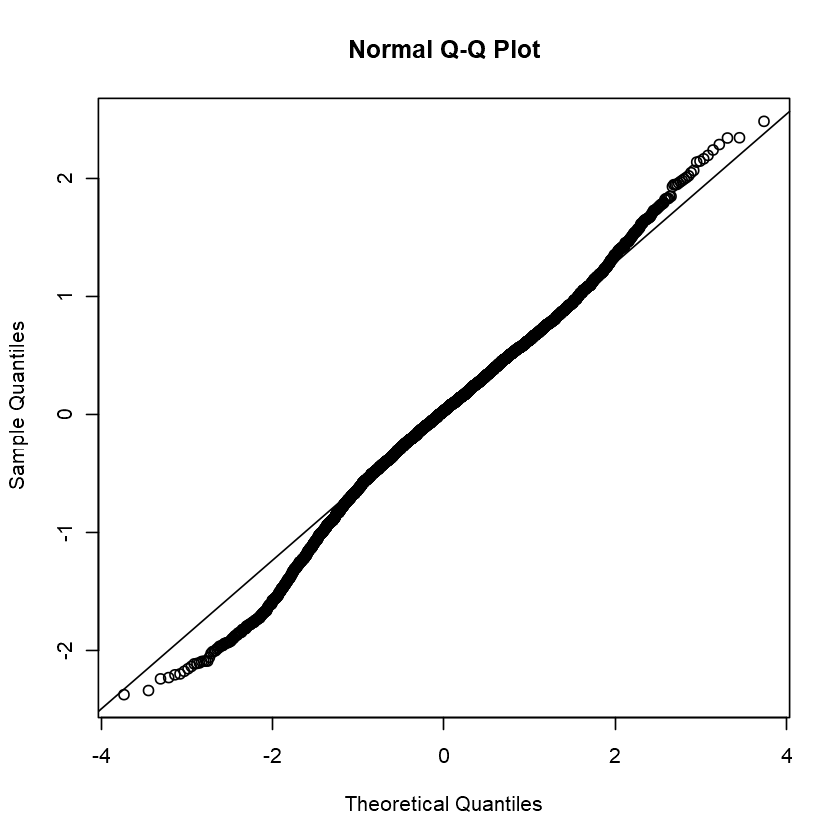

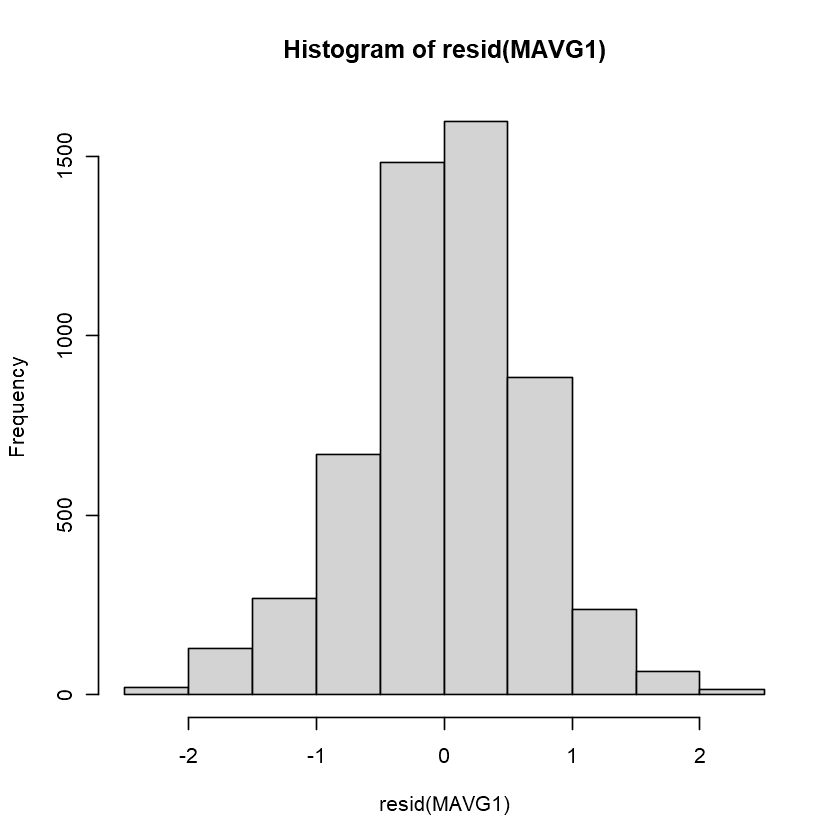

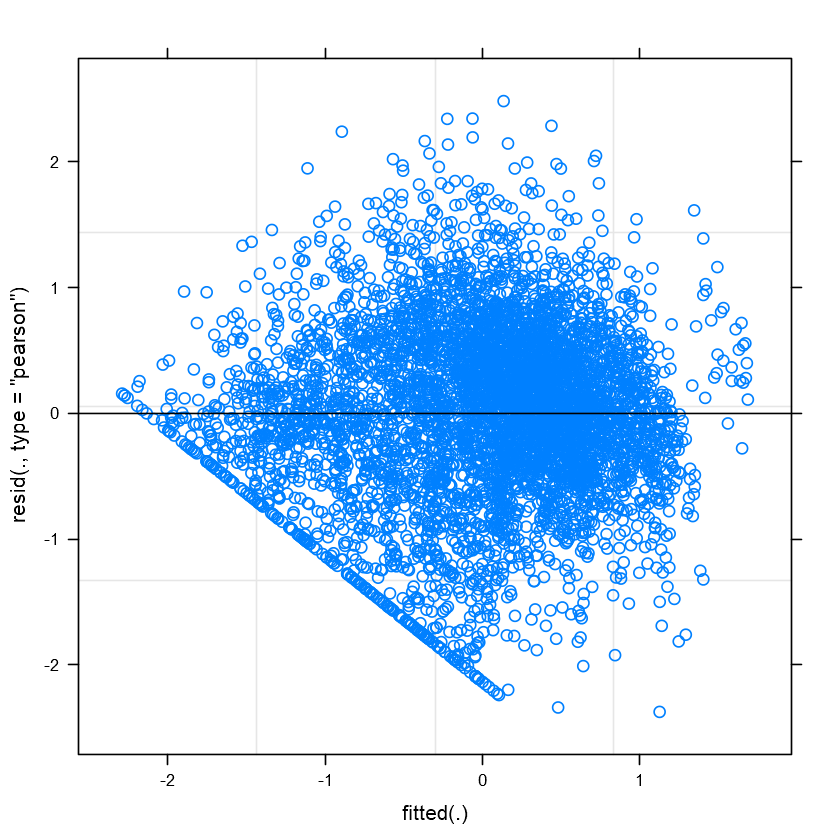

In [8]:
MAVG1 = lmer(PC1 ~ cDIB.ortho1 + Treatment_encoded + temperature_C_avg_scale + InitialWeight_kg_scale + (1|HenID), 
             REML=FALSE, data = df)
summary(MAVG1)
r.squaredGLMM(MAVG1)
###### normally distributed residuals
qqnorm(resid(MAVG1))
qqline(resid(MAVG1))
hist(resid(MAVG1))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
PC1 ~ cDIB.ortho1 + cDIB.ortho2 + Treatment_encoded + temperature_C_avg_scale +  
    InitialWeight_kg_scale + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11259.0  11311.7  -5621.5  11243.0     5353 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2784 -0.5652  0.0193  0.6022  3.8048 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3973   0.6303  
 Residual             0.4358   0.6601  
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              -0.002337   0.055402  -0.042
cDIB.ortho1              11.317912   0.695885  16.264
cDIB.ortho2             -16.426779   0.739312 -22.219
Treatment_encoded        -0.217848   0.056139  -3.880
temperature_C_avg_scale  -0.022738   0.010510  -2.164
InitialWeight_kg_scale    0.020740   0.056120   0.370

Correlation of Fixed Effects:

R2m,R2c
0.125074,0.5423339


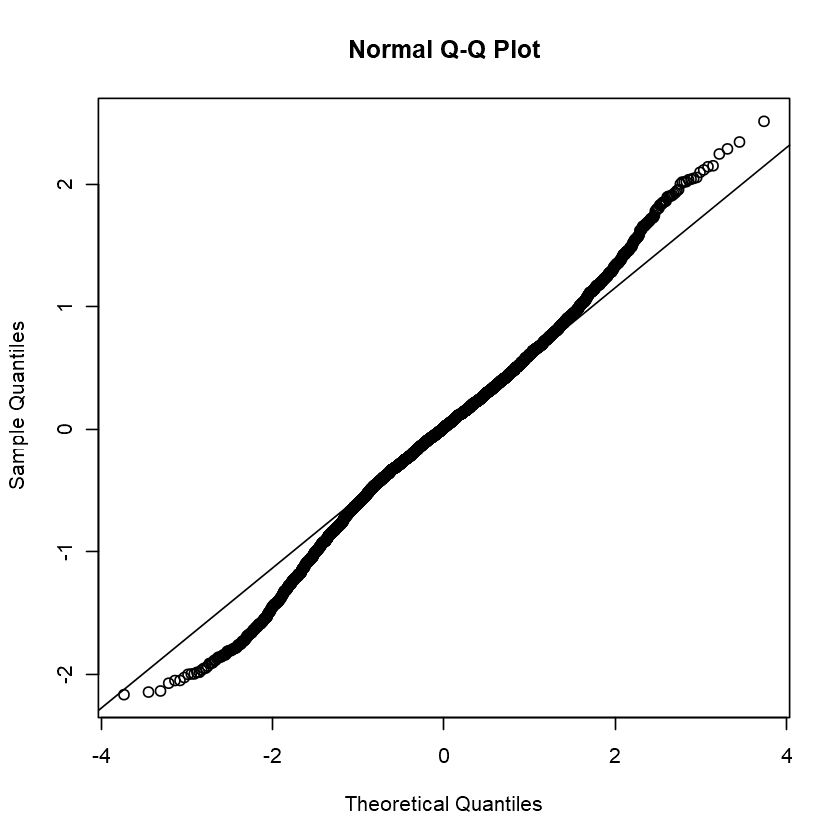

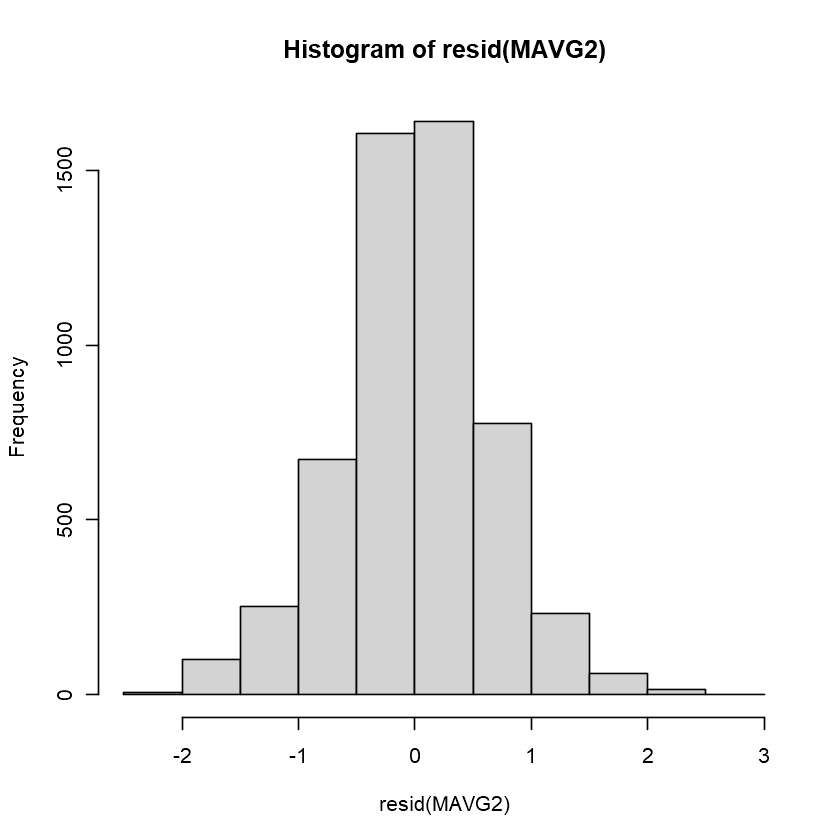

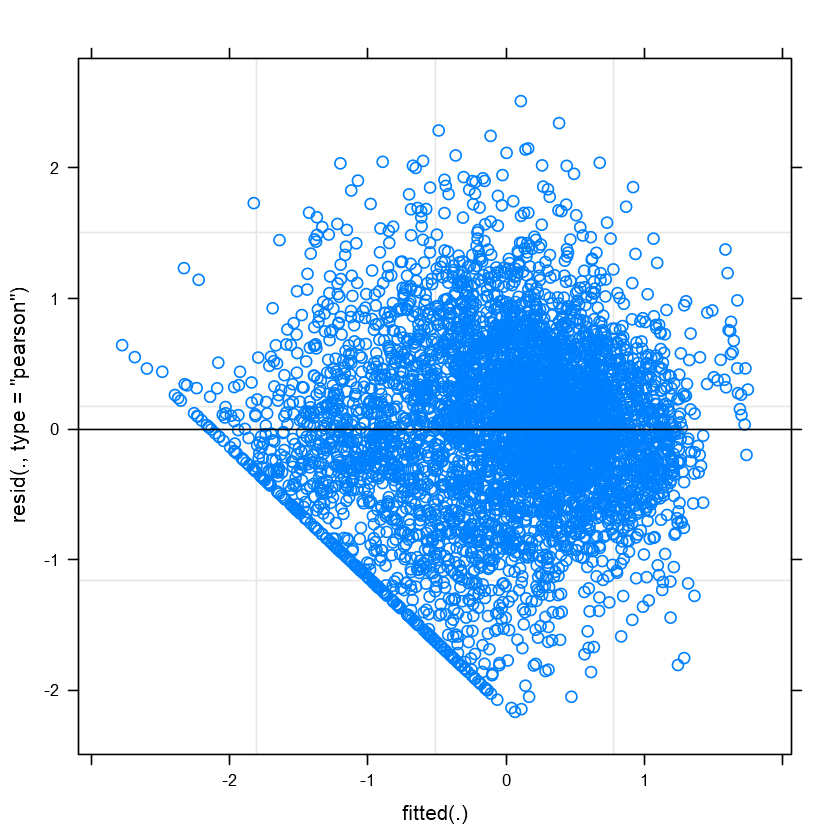

In [9]:
#we use raw=TRUE to be comparable, but then we will set it to FALSE to avoid collineartiy issues
#poly(cDIB, 2, raw = FALSE)1 is the slope coefficient of the quadratic function 
#poly(cDIB, 2, raw = FALSE)2 is the quadratic coefficient of the quadratic functionthat reflects the curvature of the regression
MAVG2 = lmer(PC1 ~ cDIB.ortho1 + cDIB.ortho2 + Treatment_encoded + temperature_C_avg_scale + InitialWeight_kg_scale + (1|HenID), REML=FALSE, data = df)
summary(MAVG2)
r.squaredGLMM(MAVG2)
###### normally distributed residuals
qqnorm(resid(MAVG2))
qqline(resid(MAVG2))
hist(resid(MAVG2))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG2)

## Comparing models & repeatabilities & save corresponding data

In [10]:
anova(MAVG2, MAVG1, test="Chisq")

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAVG1,7,11728.76,11774.87,-5857.382,11714.76,NA,NA,NA
MAVG2,8,11258.97,11311.66,-5621.484,11242.97,471.7969,1,1.302397e-104


In [11]:
#repeatabilities
print(VarCorr(MAVG2),comp =c("Variance","Std.Dev."))
rep = VarCorr(MAVG2)$"HenID"[1]/
(VarCorr(MAVG2)$"HenID"[1]+
 attr(VarCorr(MAVG2), "sc")^2) # equal to the variance of residual
#alternatively: 0.39815  /(0.39815  +0.47685)
rep

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.39729  0.63031 
 Residual             0.43576  0.66012 


[1] 0.4769088

In [12]:
#or with posterior distribtion with 1000 simulations and credible interval
set.seed(1)
simulated = sim(MAVG2, n.sim = 1000)
posterior_HenID = apply(simulated@ranef$"HenID"[ , , 1],1,var)
posterior_residual  = simulated@sigma^2
quantile(posterior_HenID/
         (posterior_HenID+posterior_residual), prob=c(0.025, 0.5, 0.975))

2.5%       50%     97.5% 
0.4641310 0.4814027 0.5001730

In [13]:
#BLUP intercepts: behavioural type individual estiamtes with mer-Tools (obtaining repeated samples from the posterior distribution
#of the model from which we can calculate the stdev for each individual)
#as PC1 is not interpretable as much as "total distance travelled" would, we wont add the population-level estimate
#done in "studing..."
#as for our purpose it wont change anything
set.seed(1)
simulated_individualbehaviouraltype = REsim(MAVG2, n.sims = 1000)
head(simulated_individualbehaviouraltype,3)
write.csv(simulated_individualbehaviouraltype,file.path(path_,'Adaptability','IndividualBehaviouralType.csv'),row.names = FALSE)

,groupFctr,groupID,term,mean,median,sd
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,HenID,hen_1,(Intercept),-0.8335564,-0.8343624,0.1305772
2,HenID,hen_10,(Intercept),-0.2818203,-0.2799886,0.1663218
3,HenID,hen_101,(Intercept),0.6837794,0.6794952,0.1597599


### early short-term consistency

modelSTCon = lmer(vertical_travel_distance_perh ~ cDIB + Treatment + temperature_C_avg + InitialWeight_kg + (1|HenID), 
               REML=TRUE, data=df[ which(df$WIB==1), ])
summary(modelSTCon)
r.squaredGLMM(modelSTCon)

#normally distributed residuals
qqnorm(resid(modelBT))
qqline(resid(modelBT))
hist(resid(modelBT))
#check homogeneity of variance (residuals has constant variance)
plot(modelBT)

#repeatabilities
print(VarCorr(modelBT),comp =c("Variance","Std.Dev."))
rep = VarCorr(modelBT)$"HenID"[1]/
(VarCorr(modelBT)$"HenID"[1]+
 attr(VarCorr(modelBT), "sc")^2) # equal to the variance of residual
#alternatively: 0.39815  /(0.39815  +0.47685)
rep

# Plasticity

Linear mixed model fit by REML ['lmerMod']
Formula: 
PC1 ~ cDIB.ortho1 + cDIB.ortho2 + Treatment_encoded + temperature_C_avg_scale +  
    InitialWeight_kg_scale + (1 + cDIB.ortho1 | HenID)
   Data: df

REML criterion at convergence: 9618.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9814 -0.5671 -0.0137  0.5557  4.7425 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 HenID    (Intercept)   0.4124  0.6422       
          cDIB.ortho1 739.7801 27.1989  -0.19
 Residual               0.2956  0.5437       
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              -0.002528   0.056193  -0.045
cDIB.ortho1              11.384165   2.429154   4.686
cDIB.ortho2             -16.678991   0.612367 -27.237
Treatment_encoded        -0.203918   0.055997  -3.642
temperature_C_avg_scale  -0.023116   0.008659  -2.670
InitialWeight_kg_scale   -0.001453   0.055996  -0.026

Correlation of Fixed

R2m,R2c
0.1207039,0.6927327


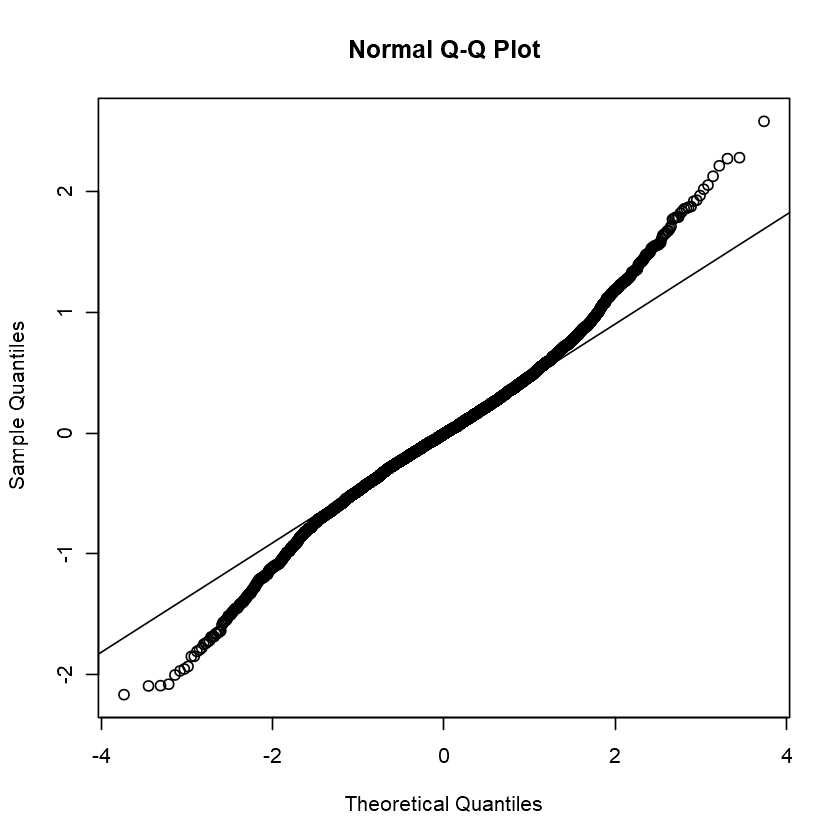

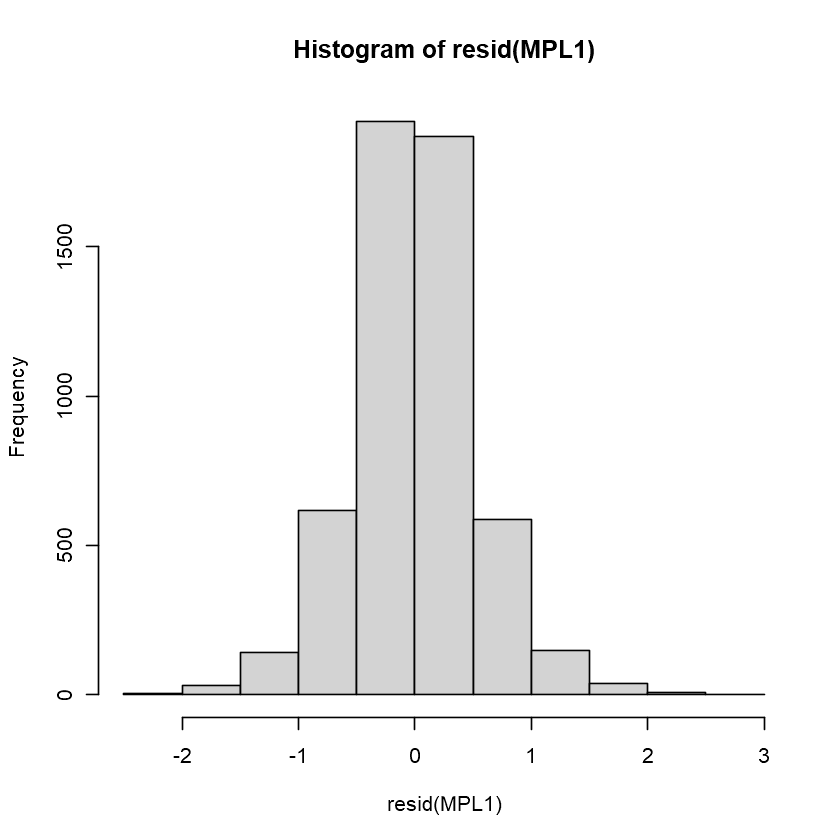

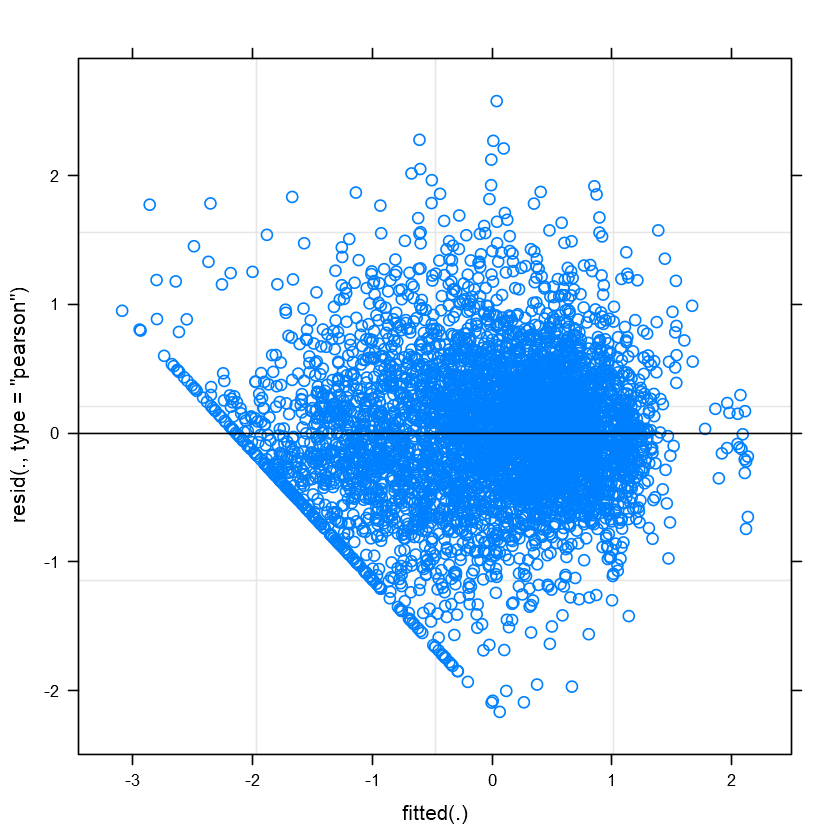

In [14]:
#random interecepts and slopes over DIB for each animal (interactio between DIB and henID as a random effect)
MPL1 = lmer(PC1 ~ cDIB.ortho1 + cDIB.ortho2 + Treatment_encoded + temperature_C_avg_scale + InitialWeight_kg_scale + (1 + cDIB.ortho1|HenID), 
                REML=TRUE, data=df)
summary(MPL1)
r.squaredGLMM(MPL1)
###### normally distributed residuals
qqnorm(resid(MPL1))
qqline(resid(MPL1))
hist(resid(MPL1))
######check homogeneity of variance (residuals has constant variance)
plot(MPL1)

Linear mixed model fit by REML ['lmerMod']
Formula: 
PC1 ~ cDIB.ortho1 + cDIB.ortho2 + Treatment_encoded + temperature_C_avg_scale +  
    InitialWeight_kg_scale + (1 + cDIB.ortho1 + cDIB.ortho2 |      HenID)
   Data: df

REML criterion at convergence: 9077.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2203 -0.5545 -0.0076  0.5459  5.1371 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 HenID    (Intercept)   0.4142  0.6436             
          cDIB.ortho1 753.9592 27.4583  -0.19      
          cDIB.ortho2 217.9452 14.7630  -0.14 -0.18
 Residual               0.2528  0.5028             
Number of obs: 5361, groups:  HenID, 133

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              -0.002024   0.056252  -0.036
cDIB.ortho1              11.534329   2.442696   4.722
cDIB.ortho2             -16.885874   1.403085 -12.035
Treatment_encoded        -0.186161   0.055335  -3.364
temperature_C_avg_scale  -0.024443

R2m,R2c
0.1153767,0.7363964


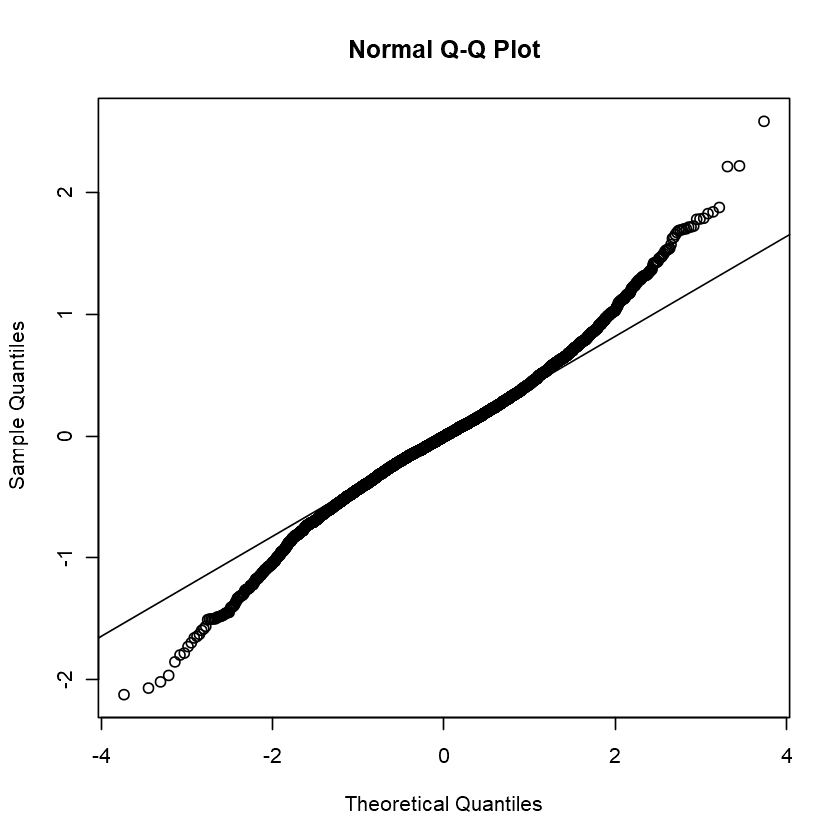

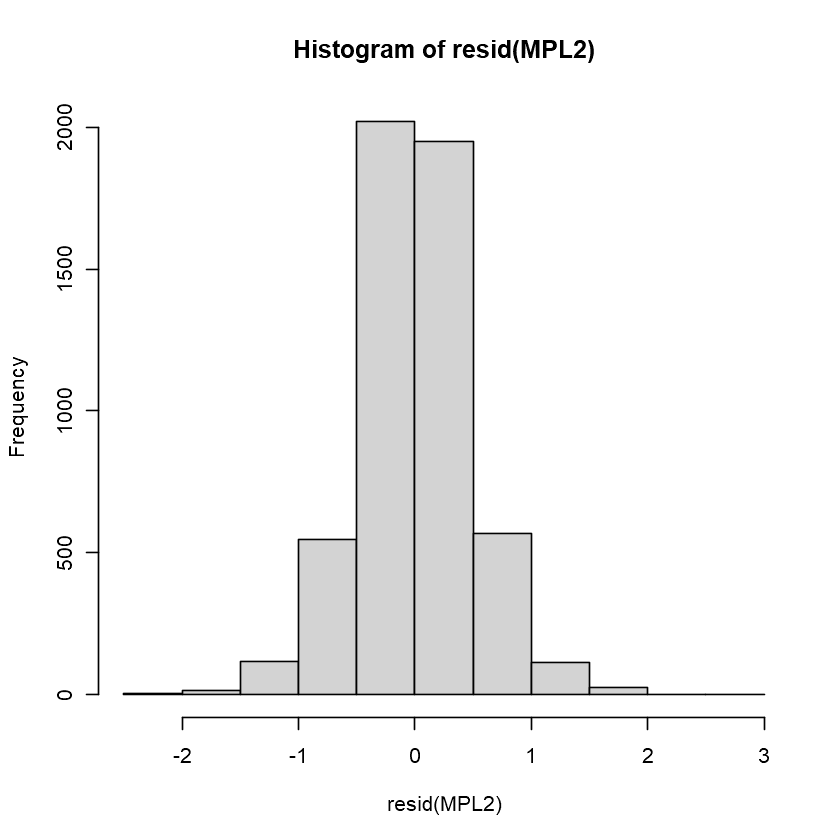

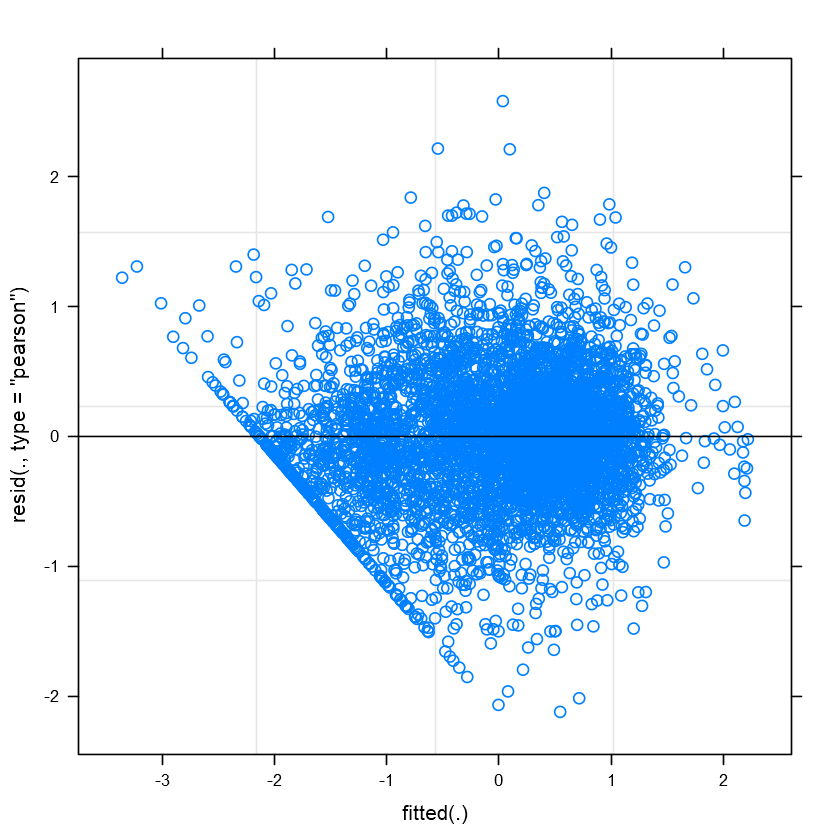

In [15]:
#test whether a nonlinear random slope over DIB improve model fit
MPL2 = lmer(PC1 ~ cDIB.ortho1 + cDIB.ortho2 + Treatment_encoded + temperature_C_avg_scale + InitialWeight_kg_scale + (1 + cDIB.ortho1 + cDIB.ortho2|HenID), 
                REML=TRUE, data=df)
#control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb'))
summary(MPL2)
r.squaredGLMM(MPL2)
###### normally distributed residuals
qqnorm(resid(MPL2))
qqline(resid(MPL2))
hist(resid(MPL2))
######check homogeneity of variance (residuals has constant variance)
plot(MPL2)

## Comparing models & save corresponding data

In [16]:
#LRT from anova is not correct anymore as we compare parameters that are on the boundery (random effects)
#LRT MAVG2 and MPL1 (i.e. compare  model with the random intercept and the model with random intercept and slope)
#Same as my citation from: https://link.springer.com/content/pdf/10.1007%2F978-0-387-87458-6_5.pdf (chapter 5 of the book)
summary(MAVG2)$logLik
summary(MPL1)$logLik
AIC(MAVG2, MPL1)
L = -2*(summary(MAVG2)$logLik -summary(MPL1)$logLik)
L
pval = 0.5 * ((1 - pchisq(L, df=1)) + (1 - pchisq(L, df=2))) 
pval
#if p-value < 0.001. reject H0, This means that adding random slope to the model is a significant improvement

'log Lik.' -5621.484 (df=8)

'log Lik.' -4809.217 (df=10)

,df,AIC
,<dbl>,<dbl>
MAVG2,8,11258.968
MPL1,10,9638.435


'log Lik.' 1624.533 (df=8)

'log Lik.' 0 (df=8)

In [17]:
#LRT MPL1 and MPL2 (i.e. with DPT compared to DPT2)
#Same as before as its a special case of only one parameter hitting the boundary
#should be correct based on https://stats.stackexchange.com/questions/16013/allowed-comparisons-of-mixed-effects-models-random-effects-primarily/16015#16015
AIC(MPL2, MPL1)
L = -2*(summary(MPL1)$logLik -summary(MPL2)$logLik)
L
pval = 0.5 * ((1 - pchisq(L, df=1)) + (1 - pchisq(L, df=2))) 
pval
#if p-value < 0.001. reject H0, This means that adding quadratic term to the model is a significant improvement: use the more complex model!

,df,AIC
,<dbl>,<dbl>
MPL2,13,9103.384
MPL1,10,9638.435


'log Lik.' 541.0514 (df=10)

'log Lik.' 0 (df=10)

#### daily predicted value

In [18]:
#done in "phenotypic plant..."
#daily predicted value
df$pred_pop  = predict(MPL2, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MPL2, re.form = NULL)
write.csv(df, file.path(path_,'Adaptability','EstimatedPlasticity.csv'), row.names = FALSE)
head(df,3)

,WIB,HenID,RPen,DIB,CLASS,TrackingSystemID,PenID,temperature_C_avg,Treatment,tobeusedPCA,...,cDIBfact,InitialWeight_kg,PC1,temperature_C_avg_scale,InitialWeight_kg_scale,cDIB_scale,cDIB.ortho1,cDIB.ortho2,pred_pop,pred_HenID
,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<int>,...,<fct>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>
1,2,hen_131,4,11,Other,TrackingSystem 10-12,pen10,11.50000,TRAN,1,...,11,1.202,-0.02559792,0.2055965,0.5334099,-1.834416,-0.02505621,0.03347133,-0.6726142,-0.3154739
2,2,hen_131,4,12,Other,TrackingSystem 10-12,pen10,10.16667,TRAN,0,...,12,1.202,-0.12844268,-0.2138708,0.5334099,-1.753085,-0.02394531,0.02923338,-0.5779863,-0.2078568
3,2,hen_131,4,13,Other,TrackingSystem 10-12,pen10,9.00000,TRAN,0,...,13,1.202,-0.23882933,-0.5809047,0.5334099,-1.671754,-0.02283442,0.02519035,-0.4879316,-0.1058592


#### BLUP: individual estimates with uncertainty values

In [19]:
set.seed(1)
#REsim already synthesis results compare to the sim(). I verified manually
simulated_individualplasticity = REsim(MPL2, n.sim = 1000)
head(simulated_individualplasticity,3)
write.csv(simulated_individualplasticity, file.path(path_,'Adaptability','IndividualPlasticity.csv'), row.names = FALSE)

,groupFctr,groupID,term,mean,median,sd
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,HenID,hen_1,(Intercept),-0.9116573,-0.9621303,1.460951
2,HenID,hen_10,(Intercept),-0.3228200,-0.3470126,1.506583
3,HenID,hen_101,(Intercept),0.6934166,0.6777491,1.539373


# Predictibility

In [24]:
#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula= PC1~ poly(cDIB_scale,2,raw=FALSE) + Treatment_encoded + InitialWeight_kg_scale + temperature_C_avg_scale + (1+poly(cDIB_scale,2,raw=FALSE)|HenID), data=df, family = gaussian())

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,InitialWeight_kg_scale,,,,,,default
,b,polycDIB_scale2rawEQFALSE1,,,,,,default
,b,polycDIB_scale2rawEQFALSE2,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,Treatment_encoded,,,,,,default
lkj(1),cor,,,,,,,default
,cor,,HenID,,,,,default
"student_t(3, 0.2, 2.5)",Intercept,,,,,,,default


Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ poly(cDIB_scale, 2) + Treatment_encoded + InitialWeight_kg_scale + temperature_C_avg_scale + (1 + poly(cDIB_scale, 2) | HenID) 
         sigma ~ (1 | HenID)
   Data: df (Number of observations: 5361) 
  Draws: 10 chains, each with iter = 5000; warmup = 2500; thin = 3;
         total post-warmup draws = 8334

Group-Level Effects: 
~HenID (Number of levels: 133) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.65      0.04     0.58     0.74
sd(polycDIB_scale21)                      27.28      1.77    24.05    30.95
sd(polycDIB_scale22)                      13.99      1.05    12.07    16.14
sd(sigma_Intercept)                        0.29      0.02     0.25     0.33
cor(Intercept,polycDIB_scale21)           -0.19      0.09    -0.35    -0.02
cor(Intercept,polycDIB_scale22)           -0.14      0.09    -0.32     0.04
cor(polycDIB_scale21,polycDIB_sca

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 0.2965438

,lower,upper
var1,0.2532185,0.3421223


Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,InitialWeight_kg_scale,,,,,,default
,b,polycDIB_scale21,,,,,,default
,b,polycDIB_scale22,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,Treatment_encoded,,,,,,default
"student_t(3, 0.2, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",Intercept,,,,sigma,,,default
lkj_corr_cholesky(1),L,,,,,,,default


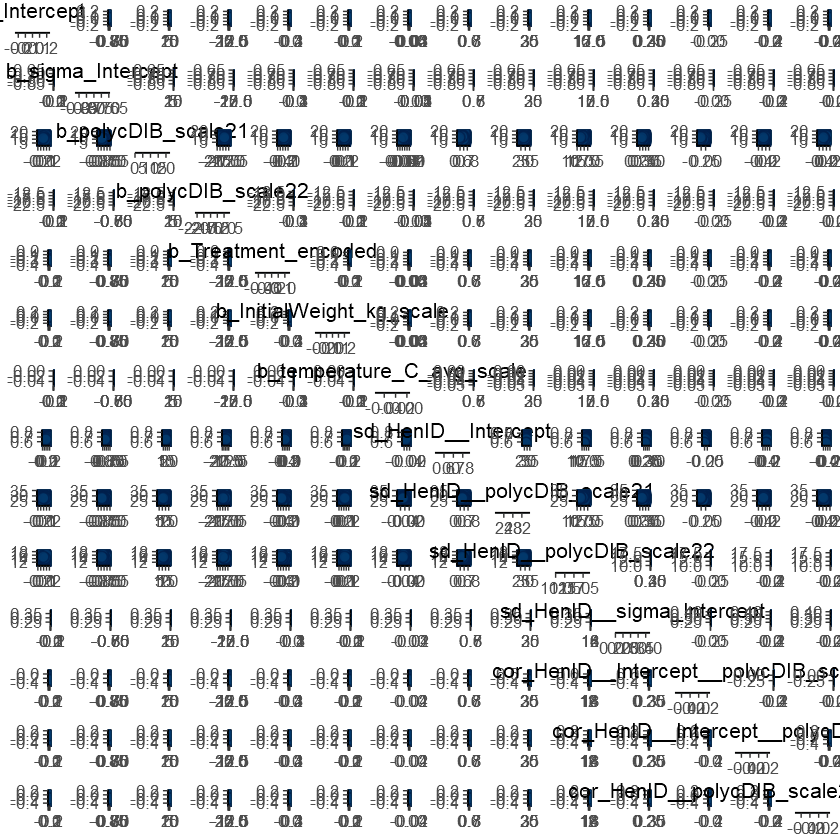

In [7]:
#help(brms) #to cite STAN for the following info:
### bulk-ESS: We recommend requiring that the bulk-ESS is greater than 100 times the number of chains. For example, when running 
#4 chains, this corresponds to having a rank-normalized effective sample size of at least 400.
### R-hat: We recommend running at least four chains by default and only using the sample if R-hat is less than 1.01.
#more info: #https://mc-stan.org/misc/warnings.html#bulk-ess%22
double_model = bf(PC1~ poly(cDIB_scale,2,raw=FALSE) + Treatment_encoded + InitialWeight_kg_scale + temperature_C_avg_scale + (1+poly(cDIB_scale,2,raw=FALSE)|HenID), sigma~(1|HenID))
modelPred = brm(double_model, data=df, iter=15000, inits="random", seed=12345, control = list(max_treedepth = 15), 
                cores=my.cores, chains=10, thin=3)
             #prior = c(set_prior("student_t(1, 0.01, 0.001)", coef = "temperature_C_avg_scale"),
             #         set_prior("student_t(1, 0.01, 0.001)", coef = "cDIB_scale")))
#modelPred = add_criterion(modelPred, "waic")
summary(modelPred)
pairs(modelPred)

#coefficient of variation in predictability” (CVP)
log.norm.res = exp(posterior_samples(modelPred)$"sd_HenID__sigma_Intercept"^2)
CVP = sqrt(log.norm.res-1)
mean(CVP);HPDinterval(as.mcmc(CVP),0.95)
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
#extract samples (draw) from the posterior distribution, including all variables
df_pred = as_draws(modelPred)
write.csv(df_pred, file.path(path_,'Adaptability','IndividualPredictability.csv'), row.names = FALSE)
prior_summary(modelPred)

In [15]:
#mean population-level residual variance
fixef(modelPred, pars = "sigma_Intercept")[1]

[1] -0.7612837

In [17]:
#add score and save model
add_criterion(modelPred, criterion='bayes_R2', file=file.path(path_adapt,'BRMS_Model_variance'))
#model can be retrieve like this: modelPred = readRDS(file.path(path_adapt,'BRMS_Model_variance.rds'))
#summary(modelPred)

 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ poly(cDIB_scale, 2) + Treatment_encoded + InitialWeight_kg_scale + temperature_C_avg_scale + (1 + poly(cDIB_scale, 2) | HenID) 
         sigma ~ (1 | HenID)
   Data: df (Number of observations: 5361) 
  Draws: 10 chains, each with iter = 5000; warmup = 2500; thin = 3;
         total post-warmup draws = 8334

Group-Level Effects: 
~HenID (Number of levels: 133) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.65      0.04     0.58     0.74
sd(polycDIB_scale21)                      27.28      1.77    24.05    30.95
sd(polycDIB_scale22)                      13.99      1.05    12.07    16.14
sd(sigma_Intercept)                        0.29      0.02     0.25     0.33
cor(Intercept,polycDIB_scale21)           -0.19      0.09    -0.35    -0.02
cor(Intercept,polycDIB_scale22)           -0.14      0.09    -0.32     0.04
cor(polycDIB_scale21,polycDIB_sca

In [ ]:
#https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html

#### posterior predictive check

Warning message:
"Argument 'nsamples' is deprecated. Please use argument 'ndraws' instead."


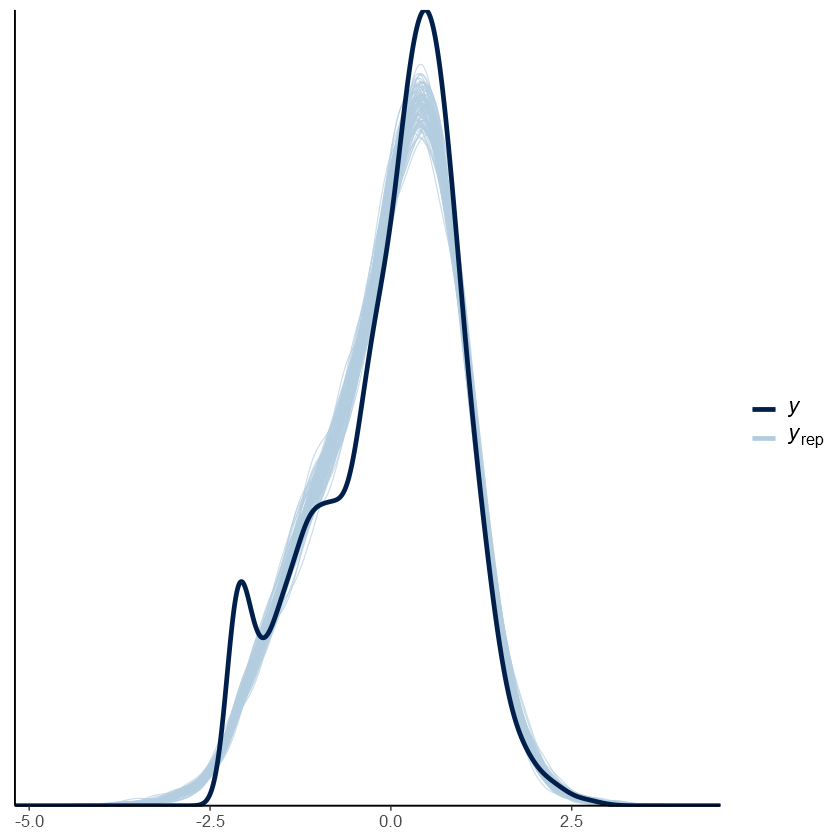

In [71]:
pp_check(modelPred, nsamples = 100)
#-->we don't see any major systematic discrepancies of our data from what can be predicted with modelPred

In [ ]:
#additonally marginal model plots could be done with : https://github.com/marklhc/usc-psyc621-notes/blob/master/mmp_brm.R
#as explained here: https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html#diagnostic-tools